<a href="https://colab.research.google.com/github/AdamDlubak/Ki67/blob/master/Main_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialization

### Install packages

In [1]:
!pip install opencv-python
!pip install boolean.py
!pip install -U scikit-fuzzy
!pip install pyswarms

    100% |████████████████████████████████| 1.0MB 20.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/81/d9/eb/b8321c08339f51be3e991e7ae45b9673270cb8ca8271482ab1
Successfully built scikit-fuzzy


### Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Import Libraries

In [0]:
%matplotlib inline
import re
import cv2
import math
import pickle
import numpy as np
import pandas as pd
from os import listdir
import scipy.ndimage as ndimage
from matplotlib import pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import boolean
from IPython.display import HTML, display
import time
from tqdm import tnrange, tqdm_notebook
from time import sleep


import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import plot_cost_history, plot_contour, plot_surface
import matplotlib.pyplot as plt
from pyswarms.utils.plotters.formatters import Mesher, Designer


### Variables

In [0]:
# images_folder = '/content/gdrive/My Drive/Praca Dyplomowa/Projekt/Graphics/'
images_folder = '/content/gdrive/My Drive/Praca Dyplomowa/Projekt/Color/'
files_folder = '/content/gdrive/My Drive/Praca Dyplomowa/Projekt/'

extension = '.jpg'
# image_name = 'flower_image_'
image_name = 'image_'

reduct_file = 'Reduct.p'
rules_file = 'Rules.p'

footprint = np.ones((3, 3))
footprint[1][1] = 3

# d_low = "Low Violet"
# d_average = "Average Violet"
# d_very = "Very Violet"

d_low = "Low Color"
d_average = "Average Color"
d_very = "Very Color"

low = "Low"
middle = "Middle"
high = "High"

sigma = 0.1
features_numbers = 6
set_min = 0 
set_max = 1
fuzzy_sets_precision = 0.000001

## Read and Prepare Images

### Display image functions

In [0]:
def print_image(image, title = ""):
  fig = plt.figure()
  fig.suptitle(title, fontsize = 13)
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def print_images(image_1, image_2, image_3, image_4, image_5, image_6, title_1 = "", title_2 = "", title_3 = "", title_4 = "", title_5 = "", title_6 = ""):
  fig = plt.figure(figsize=(18, 18))
  ax= plt.subplot(161)
  ax.set_title(title_1, fontsize = 13)
  plt.axis('off')
  plt.imshow(image_1)
  
  ax = plt.subplot(162)
  ax.set_title(title_2, fontsize = 13)
  plt.axis('off')
  plt.imshow(image_2)
  
  ax = plt.subplot(163)
  ax.set_title(title_3, fontsize = 13)
  plt.axis('off')
  plt.imshow(image_3)
  
  ax = plt.subplot(164)
  ax.set_title(title_4, fontsize = 13)
  plt.axis('off')
  plt.imshow(image_4)
 
  ax = plt.subplot(165)
  ax.set_title(title_5, fontsize = 13)
  plt.axis('off')
  plt.imshow(image_5)

  ax = plt.subplot(166)
  ax.set_title(title_6, fontsize = 13)
  plt.axis('off')
  plt.imshow(image_6)
  
  plt.show() 
  

### Image preparation functions

In [0]:

def average_func(values):
  return np.average(values)

def threshold_binary(image, min_value, max_value):
  _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  return thresh

def split_into_rgb_channels(image):
  b, g, r = cv2.split(image)
  return r, g, b

def split_into_hsv_channels(image):
  hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  h, s, v = cv2.split(hsv_image)
  return h, s, v

def prepare_image(image, image_type, width = 100, height = 30):
  # Resize
  resized_image = cv2.resize(image, (width, height)) 
#   resized_image = image
  # Remove background
  gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
  
#   thresh = threshold_binary(gray_image, 20, 255) 
  # Get R G B and H S V colors
  r_image, g_image, b_image = split_into_rgb_channels(resized_image) 
  h_image, s_image, v_image = split_into_hsv_channels(resized_image) 
  
  if image_type == "r":
    color_image = r_image
  elif image_type == "g":
    color_image = g_image
  elif image_type == "b":
    color_image = b_image
  elif image_type == "h":
    color_image = h_image
  elif image_type == "s":
    color_image = s_image
  else:
    color_image = v_image

    
  # Mean of pixel & neighbours
#   image_features = ndimage.generic_filter(color_image, average_func, footprint=footprint, mode='constant', cval=1)
  image_features = []
  stepSize = 5
  (w_width, w_height) = (5, 5)
  for x in range(0, color_image.shape[0] + 1- w_width , stepSize):
     for y in range(0, color_image.shape[1] + 1- w_height, stepSize):
        image_features.append(np.average(color_image[x:x + w_width, y:y + w_height]))
  
#   print(image_features)
#   image_features_without_bg = np.copy(image_features)
#   for x in range(len(image_features)):
#     for y in range(len(image_features[0])):
#       if thresh[x][y] == 255:
#         image_features_without_bg[x][y] = 255

  # Print images step by step
#   print_images(resized_image, gray_image, thresh, color_image, image_features, image_features_without_bg, "Resized Image", "Grey Image", "Background removing", "Color Image", "Image Features", "Image Features with threshold")
  
  # Spłaszcz
#   features_without_bg = image_features_without_bg.ravel()
  
  # Usuń wartości dotyczące tła
#   features_without_bg = list(filter(lambda x: x != 255, features_without_bg))
#   return [sum(features_without_bg) / float(len(features_without_bg))]
#   return features_without_bg
  return image_features

### Read Images

In [10]:
images = [d_low, d_average, d_very]
features_array = []
features_table = pd.DataFrame()

for images_type_folder in [d_low, d_average, d_very]:
  for name in listdir(images_folder + images_type_folder):
    file_path = images_folder + images_type_folder + "/" + name
    features_array.append(extract_features_from_image(cv2.imread(file_path), Decision[images_type_folder].label, name.replace(extension, '')))
    
features_table = pd.concat(features_array).reset_index(drop=True)

display(features_table)

,F0,F1,F2,F3,F4,F5,Image,Decision
0,255.00,126.00,126.00,129.00,0.00,255.00,image_1,Low Color
1,255.00,126.16,126.00,129.00,0.00,255.00,image_1,Low Color
2,255.00,126.40,126.00,129.00,0.00,255.00,image_1,Low Color
3,254.84,126.24,125.68,129.32,0.00,254.84,image_1,Low Color
4,254.80,126.16,125.56,129.44,0.00,254.80,image_1,Low Color
5,254.96,127.04,126.12,128.92,0.00,254.96,image_1,Low Color
6,254.60,128.28,128.84,126.60,0.00,254.60,image_1,Low Color
7,254.88,133.20,133.28,122.00,0.00,254.88,image_1,Low Color
8,253.92,138.80,138.68,115.76,0.00,253.92,image_1,Low Color
9,252.76,142.44,142.16,111.60,0.00,252.76,image_1,Low Color


### Normalize Features

In [11]:
for x in features:
  features_table[x.label] = (features_table[x.label]-features_table[x.label].min())/(features_table[x.label].max()-features_table[x.label].min())
  
display(features_table)

,F0,F1,F2,F3,F4,F5,Image,Decision
0,1.000000,0.884551,0.886069,0.121339,0.000000,1.000000,image_1,Low Color
1,1.000000,0.885674,0.886069,0.121339,0.000000,1.000000,image_1,Low Color
2,1.000000,0.887360,0.886069,0.121339,0.000000,1.000000,image_1,Low Color
3,0.998978,0.886236,0.883813,0.123570,0.000000,0.998978,image_1,Low Color
4,0.998722,0.885674,0.882967,0.124407,0.000000,0.998722,image_1,Low Color
5,0.999744,0.891854,0.886915,0.120781,0.000000,0.999744,image_1,Low Color
6,0.997444,0.900562,0.906091,0.104603,0.000000,0.997444,image_1,Low Color
7,0.999233,0.935112,0.937394,0.072524,0.000000,0.999233,image_1,Low Color
8,0.993098,0.974438,0.975465,0.029010,0.000000,0.993098,image_1,Low Color
9,0.985685,1.000000,1.000000,0.000000,0.000000,0.985685,image_1,Low Color


## Fuzzyfication

### Fuzzy Functions

In [0]:
def gauss_left(x, mean, sigma):
  y = np.zeros(len(x))
  idx = x <= mean
  y[idx] = 1 - fuzz.gaussmf(x[idx], mean, sigma)
  return y

def gauss_right(x, mean, sigma):
  y = np.zeros(len(x))
  idx = x >= mean
  y[idx] = 1 - fuzz.gaussmf(x[idx], mean, sigma)
  return y

### Prepare Fuzzy Components

In [0]:
features = []
feature_labels = []
x_arrange = np.arange(set_min, set_max, fuzzy_sets_precision)
names = [low, middle, high]


for i in range(0, features_numbers):
  feature_label = "F" + str(i)
  features.append(ctrl.Antecedent(np.arange(set_min, set_max, fuzzy_sets_precision), feature_label))
  feature_labels.append(feature_label)
  features[i].automf(names = names)


Decision = ctrl.Consequent(np.arange(set_min, set_max, fuzzy_sets_precision), 'Decision')
Decision.automf(names=[d_low, d_average, d_very])

### Convert to Row Sets

In [0]:
def numbers_to_row_sets(idx, values, sigma, x_arrange):
  

  values = values.values
  return_array = []
  mean = values.mean()

  features[idx][low] =  gauss_left(x_arrange, mean, sigma)
  features[idx][middle] = fuzz.gaussmf(x_arrange, mean, sigma)
  features[idx][high] = gauss_right(x_arrange, mean, sigma)
 
  for x in values:
    middle_value = fuzz.gaussmf(x, mean, sigma)
    if x <= mean:
      low_value = 1 - fuzz.gaussmf(x, mean, sigma)
    else:
      low_value = 0

    if x >= mean:
      high_value = 1 - fuzz.gaussmf(x, mean, sigma)
    else:
      high_value = 0   
    
    max_value = high_value
    return_value = features[idx][high].label

    if middle_value > max_value:
      max_value = middle_value
      return_value = features[idx][middle].label

    if low_value > max_value:
      max_value = low_value
      return_value = features[idx][low].label

    return_array.append(return_value)
    
  return return_array

In [13]:
for idx, x in enumerate(features):
  features_table[x.label] = numbers_to_row_sets(idx, features_table[x.label], sigma, x_arrange)

display(features_table)

,F0,F1,F2,F3,F4,F5,Image,Decision
0,High,High,High,Low,Middle,High,image_1,Low Color
1,High,High,High,Low,Middle,High,image_1,Low Color
2,High,High,High,Low,Middle,High,image_1,Low Color
3,High,High,High,Low,Middle,High,image_1,Low Color
4,High,High,High,Low,Middle,High,image_1,Low Color
5,High,High,High,Low,Middle,High,image_1,Low Color
6,High,High,High,Low,Middle,High,image_1,Low Color
7,High,High,High,Low,Middle,High,image_1,Low Color
8,High,High,High,Low,Middle,High,image_1,Low Color
9,High,High,High,Low,Middle,High,image_1,Low Color


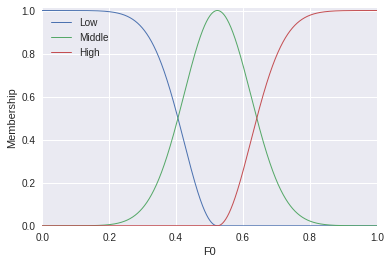

In [14]:
features[0].view()

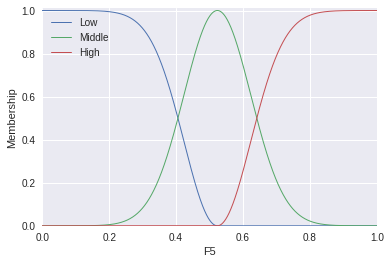

In [15]:
features[5].view()

### Remove inconsistencies

In [0]:
def get_occurence_of_rows(df, remove_columns):
  df = df.drop(remove_columns, axis=1, inplace=False)
  df = df.groupby(df.columns.tolist(),as_index=False).size().reset_index(name="Occurence")
  return df

In [17]:
features_decisions_occurence = get_occurence_of_rows(features_table, ['Image'])
display(features_decisions_occurence)

features_occurence = get_occurence_of_rows(features_table, ['Image', 'Decision'])
display(features_occurence)

,F0,F1,F2,F3,F4,F5,Decision,Occurence
0,High,High,High,Low,Middle,High,Low Color,106
1,High,High,High,Middle,Middle,High,Low Color,2
2,High,Middle,Middle,Middle,Middle,High,Low Color,12
3,Low,Low,Low,High,High,Low,Very Color,3
4,Low,Low,Low,High,Middle,Low,Average Color,1
5,Low,Low,Low,High,Middle,Low,Very Color,63
6,Low,Low,Low,Middle,Middle,Low,Average Color,3
7,Low,Low,Low,Middle,Middle,Low,Very Color,35
8,Low,Middle,Middle,Middle,Middle,Low,Very Color,19
9,Middle,Low,Low,High,Middle,Middle,Average Color,83


,F0,F1,F2,F3,F4,F5,Occurence
0,High,High,High,Low,Middle,High,106
1,High,High,High,Middle,Middle,High,2
2,High,Middle,Middle,Middle,Middle,High,12
3,Low,Low,Low,High,High,Low,3
4,Low,Low,Low,High,Middle,Low,64
5,Low,Low,Low,Middle,Middle,Low,38
6,Low,Middle,Middle,Middle,Middle,Low,19
7,Middle,Low,Low,High,Middle,Middle,83
8,Middle,Middle,Low,Middle,Middle,Middle,1
9,Middle,Middle,Middle,Middle,Middle,Middle,32


In [0]:
def get_certain_decision_rows(features_occurence, features_decisions_occurence):
  features_decision_numbers_ones = features_occurence.loc[features_occurence['Occurence'] == 1].copy()

  for index, row in features_decision_numbers_ones.iterrows():
    for idx, row_with_decision in features_decisions_occurence.iterrows():
      if (row[feature_labels].values == row_with_decision[feature_labels].values).all():   
        features_decision_numbers_ones.at[index, 'Decision'] = features_decisions_occurence.loc[idx, 'Decision']
        
  return features_decision_numbers_ones.drop(['Occurence'], axis=1, inplace=False)

def get_number_of_clear_decision(features_occurence, features_decisions_occurence):
  
  features_certain_decision = get_certain_decision_rows(features_occurence, features_decisions_occurence)
  
  tmp_table = pd.merge(features_decisions_occurence, features_certain_decision, 
                       how='inner', on=feature_labels)
  
  if 'Decision_y' in tmp_table.columns:
    tmp_table = tmp_table.drop(['Decision_y'], axis=1).rename(index=str, columns={"Decision_x": "Decision", "Occurence_x": "Occurence"})


  number_of_clear_decision = pd.DataFrame(tmp_table.groupby(['Decision'], as_index=False)['Occurence'].agg('sum'))
  
  return number_of_clear_decision

def solve_conflicts(number_of_conflicts_decision, problems_to_solve):

  for index, row in number_of_conflicts_decision.iterrows():
    new_df = pd.DataFrame(columns={"Decision", "Probability"})

    for index_2, row_2 in problems_to_solve.iterrows():
      if (row[feature_labels].values == row_2[feature_labels]).all():

        try:
          occurence = (number_of_clear_decision.loc[number_of_clear_decision['Decision'] == row_2[['Decision']].values[0]]).values[0][1]
        except:
          occurence = 0

        probability = occurence / len(features_table)
        new_df = new_df.append({'Decision': row_2[['Decision']].values, 'Probability': probability}, ignore_index=True)

    display(new_df)
    new_value = new_df.loc[new_df['Probability'].idxmax()]['Decision'][0]
  
  
    for idx, row_decision_table in features_decisions_occurence.iterrows():
      if (row[feature_labels].values == row_decision_table[feature_labels]).all():
        features_decisions_occurence.loc[idx, 'Decision'] = new_value
  
  return features_decisions_occurence

In [19]:
print("\nW tylu konflikach występuje:")
number_of_conflicts_decision = features_occurence[features_occurence.Occurence > 1]
display(number_of_conflicts_decision)

print("\nTyle jest wystąpień takich czystych decyzji:")
number_of_clear_decision = get_number_of_clear_decision(features_occurence, features_decisions_occurence)
display(number_of_clear_decision)

print("\nTe problemy należy rozwiązać:")
problems_to_solve = pd.merge(features_decisions_occurence, number_of_conflicts_decision, how='inner', on=feature_labels).drop(['Occurence_x', "Occurence_y"], axis = 1)
display(problems_to_solve)

print("Tablica decyzyjna po usunięciu duplikatów i niespójności")
features_decisions_occurence = solve_conflicts(number_of_conflicts_decision, problems_to_solve)
decision_table = features_decisions_occurence.drop(['Occurence'], axis = 1).drop_duplicates(keep='first', inplace=False)
display(decision_table)  


W tylu konflikach występuje:


,F0,F1,F2,F3,F4,F5,Occurence
0,High,High,High,Low,Middle,High,106
1,High,High,High,Middle,Middle,High,2
2,High,Middle,Middle,Middle,Middle,High,12
3,Low,Low,Low,High,High,Low,3
4,Low,Low,Low,High,Middle,Low,64
5,Low,Low,Low,Middle,Middle,Low,38
6,Low,Middle,Middle,Middle,Middle,Low,19
7,Middle,Low,Low,High,Middle,Middle,83
9,Middle,Middle,Middle,Middle,Middle,Middle,32



Tyle jest wystąpień takich czystych decyzji:


,Decision,Occurence
0,Average Color,1



Te problemy należy rozwiązać:


,F0,F1,F2,F3,F4,F5,Decision
0,High,High,High,Low,Middle,High,Low Color
1,High,High,High,Middle,Middle,High,Low Color
2,High,Middle,Middle,Middle,Middle,High,Low Color
3,Low,Low,Low,High,High,Low,Very Color
4,Low,Low,Low,High,Middle,Low,Average Color
5,Low,Low,Low,High,Middle,Low,Very Color
6,Low,Low,Low,Middle,Middle,Low,Average Color
7,Low,Low,Low,Middle,Middle,Low,Very Color
8,Low,Middle,Middle,Middle,Middle,Low,Very Color
9,Middle,Low,Low,High,Middle,Middle,Average Color


Tablica decyzyjna po usunięciu duplikatów i niespójności


,Decision,Probability
0,[Low Color],0.0


,Decision,Probability
0,[Low Color],0.0


,Decision,Probability
0,[Low Color],0.0


,Decision,Probability
0,[Very Color],0.0


,Decision,Probability
0,[Average Color],0.002778
1,[Very Color],0.000000


,Decision,Probability
0,[Average Color],0.002778
1,[Very Color],0.000000


,Decision,Probability
0,[Very Color],0.0


,Decision,Probability
0,[Average Color],0.002778


,Decision,Probability
0,[Average Color],0.002778


,F0,F1,F2,F3,F4,F5,Decision
0,High,High,High,Low,Middle,High,Low Color
1,High,High,High,Middle,Middle,High,Low Color
2,High,Middle,Middle,Middle,Middle,High,Low Color
3,Low,Low,Low,High,High,Low,Very Color
4,Low,Low,Low,High,Middle,Low,Average Color
6,Low,Low,Low,Middle,Middle,Low,Average Color
8,Low,Middle,Middle,Middle,Middle,Low,Very Color
9,Middle,Low,Low,High,Middle,Middle,Average Color
10,Middle,Middle,Low,Middle,Middle,Middle,Average Color
11,Middle,Middle,Middle,Middle,Middle,Middle,Average Color


### Discernibility Matrix

In [0]:
def get_reduct(features_table):
  
  reduct = []
  
  features_table = features_table.drop(['Decision'], axis=1)
  features_table = features_table.reset_index(drop=True)
  results = np.zeros((len(features_table), len(features_table), len(features_table.columns)))


  for index_i, i in features_table.iterrows():
    for index_j, j in features_table.iterrows():
      if index_i > index_j:
        tmp_entity = np.zeros(len(features_table.columns))
        for idx, x in enumerate(range(0, len(i.values))):
          if i[x] != j[x]:
            tmp_entity[idx] = True
        results[int(index_i), int(index_j)] = tmp_entity
        
  while True:

     
    reduct_counter = np.zeros(len(features_table.columns))

    for i in results:
      for j in i:
        for index_k, k in enumerate(j):
          if k != 0:
            reduct_counter[index_k] = reduct_counter[index_k] + 1

    print(reduct_counter)
    
    if all(item == 0 for item in reduct_counter):
      break
    
    winner = np.argwhere(reduct_counter == np.amax(reduct_counter)).flatten().tolist()

    new_to_reduct = np.random.choice(winner)
    reduct.append(new_to_reduct)

    for index_i, i in enumerate(results):
      for index_j, j in enumerate(i):
        if 1 == j[new_to_reduct]:
          results[int(index_i)][int(index_j)] = np.zeros(len(features_table.columns))
        
    if all(item == 0 for item in reduct_counter):
      break
      
  return reduct, results

In [21]:
reduct, _ = get_reduct(decision_table)

print("\nReduct - Index of features")
print(reduct)

[33. 32. 31. 27.  9. 33.]
[0. 7. 7. 8. 3. 0.]
[0. 2. 3. 0. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0.]

Reduct - Index of features
[5, 3, 2, 4]


### Reduct Operations

In [22]:
decision_table_after_reduct = decision_table[decision_table.columns[reduct]]
decision_table_after_reduct['Decision'] = decision_table['Decision']
decision_table_after_reduct = decision_table_after_reduct.reset_index(drop=True)

display(decision_table_after_reduct)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,F5,F3,F2,F4,Decision
0,High,Low,High,Middle,Low Color
1,High,Middle,High,Middle,Low Color
2,High,Middle,Middle,Middle,Low Color
3,Low,High,Low,High,Very Color
4,Low,High,Low,Middle,Average Color
5,Low,Middle,Low,Middle,Average Color
6,Low,Middle,Middle,Middle,Very Color
7,Middle,High,Low,Middle,Average Color
8,Middle,Middle,Low,Middle,Average Color
9,Middle,Middle,Middle,Middle,Average Color


### Symetric Discernibility Matrix

In [0]:
features_table = decision_table_after_reduct.drop(['Decision'], axis=1)

symetric_discernibility_matrix = np.zeros((len(features_table), len(features_table), len(reduct)))


for index_i, i in features_table.iterrows():
  for index_j, j in features_table.iterrows():
    if index_i != index_j:           # Tutaj jest różnica - nie ma ">" jest za to != tak aby uzyskać symetryczną tablicę 
      tmp_entity = np.zeros(len(reduct))
      for idx, x in enumerate(range(0, len(i.values))):
        if i[x] != j[x]:
          tmp_entity[idx] = True
      symetric_discernibility_matrix[int(index_i), int(index_j)] = tmp_entity

# print(symetric_discernibility_matrix)

In [0]:
M_matrix = np.zeros((len(symetric_discernibility_matrix), len(symetric_discernibility_matrix), len(reduct)))

for index_i, i in decision_table_after_reduct.iterrows():
  for index_j, j in decision_table_after_reduct.iterrows():
    if i['Decision'] != j['Decision']:
      M_matrix[index_i][index_j] = symetric_discernibility_matrix[index_i][index_j]
      
# print(M_matrix)

In [25]:
parameter_names = np.asarray(decision_table_after_reduct.columns)[0:-1]
print(parameter_names)

['F5' 'F3' 'F2' 'F4']


## Get Rules

In [0]:
TRUE, FALSE, NOT, AND, OR, Symbol = algebra.definition()

### Define implicants

In [26]:
implicants = []
algebra = boolean.BooleanAlgebra()

for index_i, i in enumerate(M_matrix):
  new_expression = ""
  for index_j, j in enumerate(i):
    new_subexpression = "("
    any_value = False
    for index_k, k in enumerate(j):
      if k == True:
        any_value = True
        new_subexpression = new_subexpression + parameter_names[index_k] + " | "
    if any_value:
      new_subexpression = new_subexpression[:-3] + ")"
      if new_expression != "":
        new_expression = new_expression + " & " + new_subexpression
      else:
        new_expression = new_subexpression
#   print(new_expression)
#   print(algebra.parse(new_expression))
  simplified_implicant = algebra.parse(new_expression).simplify()
#   print(simplified_implicant)
  implicants.append(simplified_implicant)

implicants

[OR(Symbol('F2'), Symbol('F3'), Symbol('F5')),
 OR(Symbol('F2'), Symbol('F5')),
 Symbol('F5'),
 Symbol('F4'),
 AND(Symbol('F4'), OR(Symbol('F2'), Symbol('F3'))),
 AND(Symbol('F2'), OR(Symbol('F3'), Symbol('F4'))),
 AND(Symbol('F2'), Symbol('F5')),
 AND(OR(Symbol('F2'), Symbol('F3'), Symbol('F5')), OR(Symbol('F4'), Symbol('F5'))),
 AND(OR(Symbol('F2'), Symbol('F5')), OR(Symbol('F3'), Symbol('F4'), Symbol('F5'))),
 Symbol('F5')]

### Generate rules from implicants

In [28]:
rules_table = []

for x in decision_table_after_reduct['Decision'].drop_duplicates():
  rules_table.append(decision_table_after_reduct.loc[decision_table_after_reduct['Decision'] == x].index.tolist())
  
print(rules_table)

[[0, 1, 2], [3, 6], [4, 5, 7, 8, 9]]


In [0]:
pattern = "F[0-9]*"

def change_implicant(index):
  def change(match):
    implicant_column_name = match.group(0)
    implicant_column_number = match.group(0)[1:]
    antecedent_part = features[int(implicant_column_number)][decision_table_after_reduct.loc[index][implicant_column_name]]
    print(str(antecedent_part.dtype))
    return str(antecedent_part)

  return change

In [0]:
rules_implicants = []
for x in rules_table:
  for idx, y in enumerate(x):
    if idx == 0:
      tmp_rule = implicants[y]
    else:
      tmp_rule = tmp_rule | implicants[y]
  rules_implicants.append(tmp_rule)

In [0]:
def cos_rob(elem, implicant_idx):
  
  if type(elem) == AND:

    for idx_x, x in enumerate(elem.args):
      if idx_x == 0:
        small_rule = cos_rob(x, implicant_idx)
      else:
        small_rule = small_rule & cos_rob(x, implicant_idx)
  
  if type(elem) == OR:
    
    for idx_x, x in enumerate(elem.args):
      if idx_x == 0:
        small_rule = cos_rob(x, implicant_idx)
      else:
        small_rule = small_rule | cos_rob(x, implicant_idx)
  
  if type(elem) == Symbol:
    implicant_column_name = str(elem)
    implicant_column_number = str(elem)[1:]
    antecedent_part = features[int(implicant_column_number)][decision_table_after_reduct.loc[implicant_idx][implicant_column_name]]
    return antecedent_part

  return small_rule
      
implicant_idx = 3
test = implicants[implicant_idx]
wynik = cos_rob(test, implicant_idx)

In [36]:
new_implicants = []

for idx_i, i in enumerate(implicants):
  new_implicants.append(cos_rob(i, idx_i))
  
  
new_implicants

[(F2[High] OR F3[Low]) OR F5[High],
 F2[High] OR F5[High],
 F5[High],
 F4[High],
 F4[Middle] AND (F2[Low] OR F3[High]),
 F2[Low] AND (F3[Middle] OR F4[Middle]),
 F2[Middle] AND F5[Low],
 ((F2[Low] OR F3[High]) OR F5[Middle]) AND (F4[Middle] OR F5[Middle]),
 (F2[Low] OR F5[Middle]) AND ((F3[Middle] OR F4[Middle]) OR F5[Middle]),
 F5[Middle]]

### Generate Rules

In [0]:
new_rules = []
for x in rules_table:
  for idx, y in enumerate(x):
    if idx == 0:
      tmp_rule = new_implicants[y]
    else:
      tmp_rule = tmp_rule | new_implicants[y]
  new_rules.append(tmp_rule)

In [0]:
rule1 = ctrl.Rule(new_rules[0], Decision[d_low])
rule2 = ctrl.Rule(new_rules[1], Decision[d_average])
rule3 = ctrl.Rule(new_rules[2], Decision[d_very])

### Make Prediction

In [0]:
tipping_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
tipping = ctrl.ControlSystemSimulation(tipping_ctrl)

tipping.input['F5'] = 0.999489
tipping.input['F3'] = 0.122455
tipping.input['F2'] = 0.884941
tipping.input['F4'] = 0.000000

tipping.compute()

print(tipping.output['Decision'])
Decision.view(sim=tipping)

## Transfer Results

### Pickle Data

In [0]:
pickle.dump( [rule1, rule2, rule3], open( files_folder + rules_file, "wb" ) )

In [0]:
pickle.dump( parameter_names, open( files_folder + reduct_file, "wb" ) )